# K-Means

K-means is a simple unsupervised machine learning algorithm that groups data into a specified number (k) of clusters. The algorithm works iteratively to assign each data point to one of K clusters based on the features that are provided. Data points are clustered based on feature similarity.

## Setup

### Set Random State Seed

In [1]:
import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)

### Import libs

In [2]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)

try:
    from src.data_loader.mnist_dataset import load_mnist_data
    from src.data_loader.toy_dataset import load_toy_data
    from src.data_loader.custom_dataset import load_custom_dataset
    from src.algorithms.k_means.k_means import KMeans
except ModuleNotFoundError as e:
    print(e)

2024-06-28 02:04:57.885203: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-28 02:04:58.291822: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-28 02:04:59.538663: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/mnt/c/Users/juanm/OneDrive/Bureau/ESGI - Projets/5IABD/5IABD_UnsupervisedDL/data/models/auto_encoder
/mnt/c/Users/juanm/OneDrive/Bureau/ESGI - Projets/5IABD/5IABD_UnsupervisedDL/data/models/gan
/mnt/c/Users/juanm/OneDrive/Bureau/ESGI - Projets/5IABD/5IABD_UnsupervisedDL/data/models/k_means
/mnt/c/Users/juanm/OneDrive/Bureau/ESGI - Projets/5IABD/5IABD_UnsupervisedDL/data/models/pca
/mnt/c/Users/juanm/OneDrive/Bureau/ESGI - Projets/5IABD/5IABD_UnsupervisedDL/data/models/som
/mnt/c/Users/juanm/OneDrive/Bureau/ESGI - Projets/5IABD/5IABD_UnsupervisedDL/data/models/vae


## Toy Data

100%|██████████| 100/100 [00:00<00:00, 111166.29it/s]


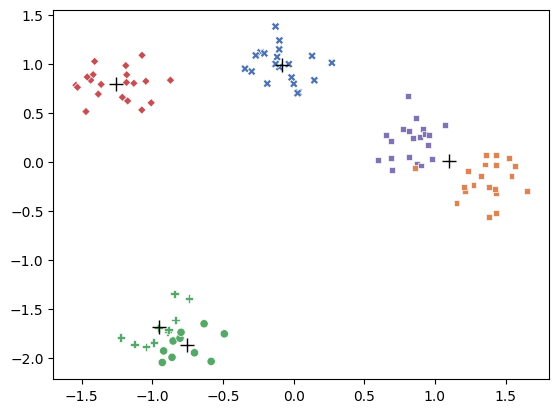

In [16]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

n_clusters = 5
x_train, y_train = load_toy_data(n_clusters=n_clusters, random_state=seed)
x_train = StandardScaler().fit_transform(x_train)

k_means = KMeans(n_clusters=n_clusters)
k_means.fit(x_train)

class_centers, classification = k_means.evaluate(x_train)
sns.scatterplot(x=[X[0] for X in x_train],
                y=[X[1] for X in x_train],
                hue=y_train,
                style=classification,
                palette="deep",
                legend=None
                )
plt.plot([x for x, _ in k_means.centroids],
         [y for _, y in k_means.centroids],
         'k+',
         markersize=10,
         )
plt.show()

## MNIST Dataset

In [17]:
(x_train, y_train), (x_test, y_test) = load_mnist_data()

### Number of clusters

In [18]:
import numpy as np

n_clusters = len(np.unique(y_train))

print(n_clusters)

10


### Training

In [19]:
k_means = KMeans(n_clusters=n_clusters)
k_means.fit(x_train)

100%|██████████| 60000/60000 [00:01<00:00, 54846.10it/s]


### Data Vizuallization

In [20]:
import matplotlib.pyplot as plt

def plot_digits(images, title: str, n_rows: int = 3, n_cols: int = 3):
    plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
    plt.suptitle(title, fontsize=16)
    for i, image in enumerate(images[:n_rows * n_cols]):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(image.reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

#### Original Images

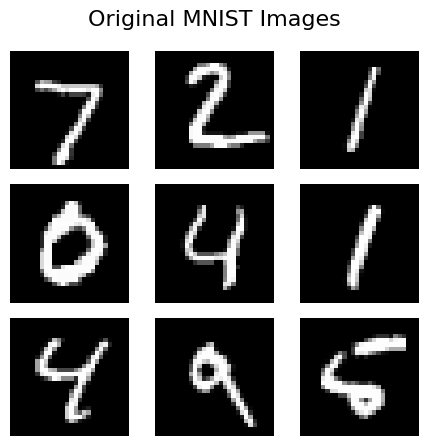

In [21]:
plot_digits(x_test, "Original MNIST Images")

#### Compressed & Decompressed

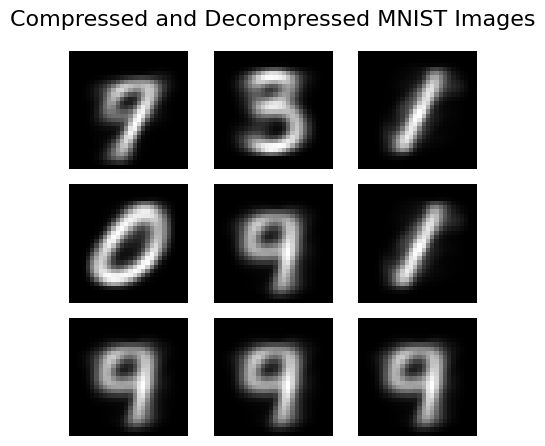

In [22]:
compressed_data = k_means.compress(x_test)
decompressed_data = k_means.decompress(compressed_data)
plot_digits(decompressed_data, "Compressed and Decompressed MNIST Images")

#### Generation

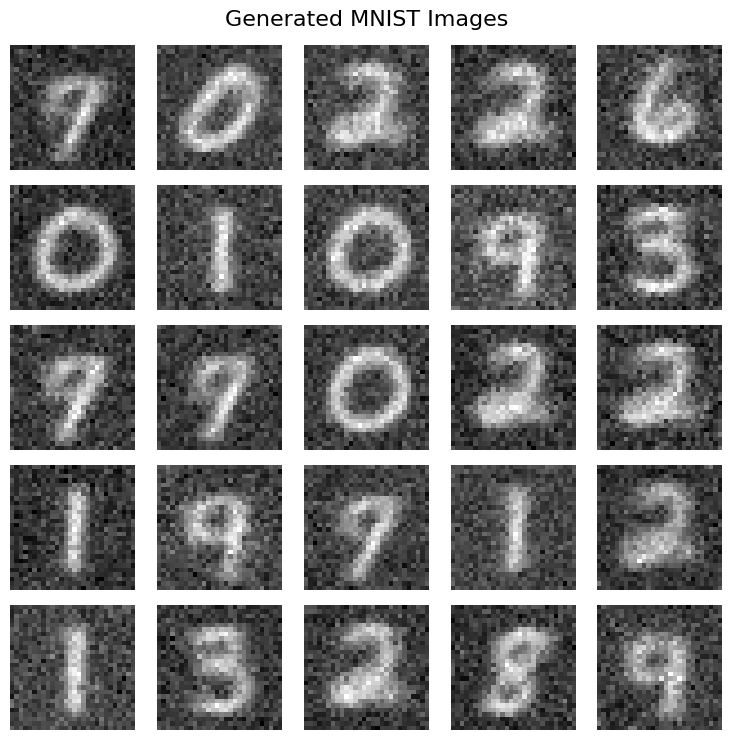

In [23]:
generated_samples = k_means.generate(n_samples=25)
plot_digits(generated_samples, "Generated MNIST Images", n_rows=5, n_cols=5)

#### Latent Space Representation

In [24]:
latent_representation_centroid = k_means.compress(x_test)

latent_representation_distance = np.array([k_means._KMeans__euclidean(x, k_means.centroids) for x in x_test])

#### Inter-Cluster Distance Heatmap

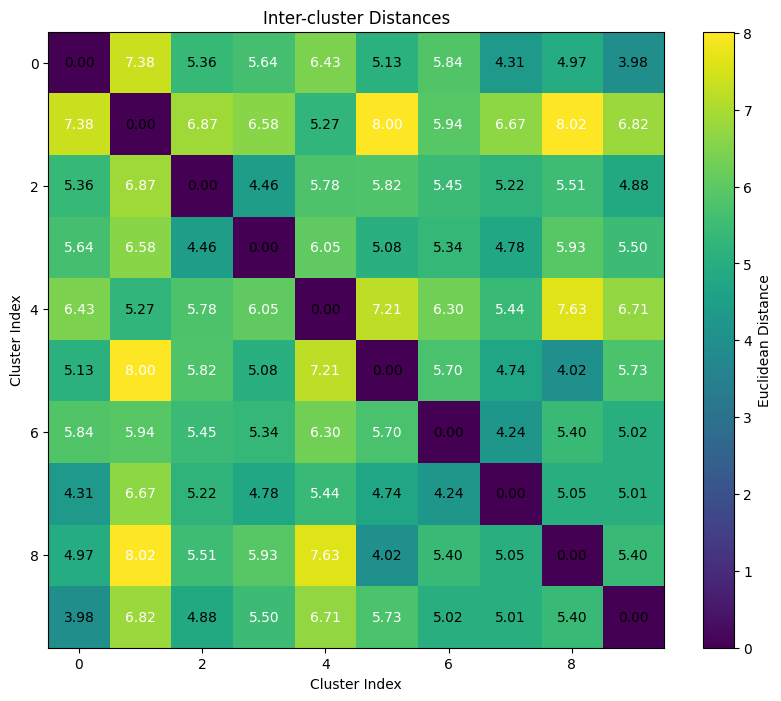

In [25]:
centroids_array = np.array(k_means.centroids)
centroid_distances = np.sqrt(
    ((centroids_array[:, None, :] - centroids_array[None, :, :]) ** 2).sum(axis=2)
)

plt.figure(figsize=(10, 8))
plt.imshow(centroid_distances, cmap="viridis")
plt.colorbar(label="Euclidean Distance")
plt.title("Inter-cluster Distances")
plt.xlabel("Cluster Index")
plt.ylabel("Cluster Index")
for i in range(n_clusters):
    for j in range(n_clusters):
        plt.text(
            j,
            i,
            f"{centroid_distances[i, j]:.2f}",
            ha="center",
            va="center",
            color=(
                "white"
                if centroid_distances[i, j] > np.median(centroid_distances)
                else "black"
            ),
        )
plt.show()

#### Cluster Distribution

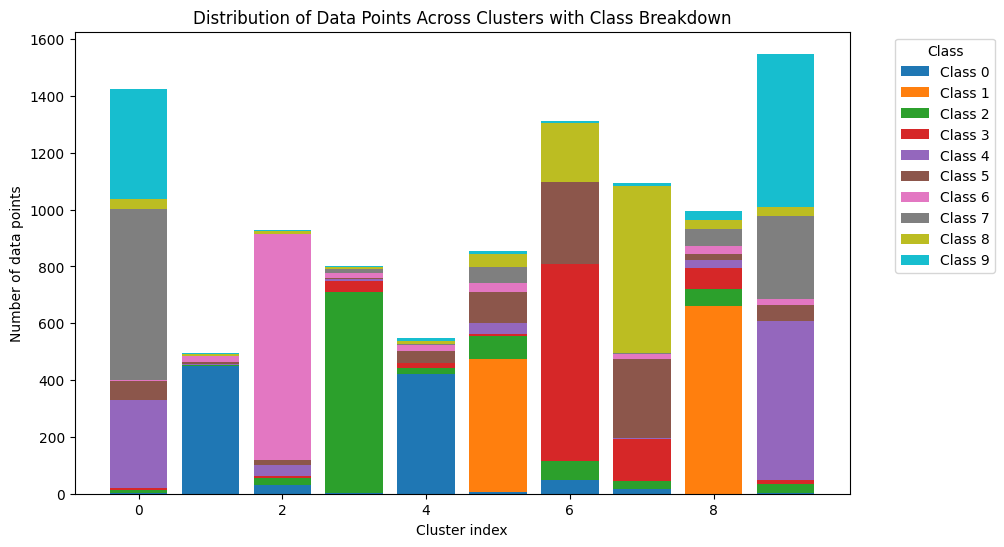

In [26]:
n_classes = len(np.unique(y_train))
cluster_class_counts = np.zeros((n_clusters, n_classes), dtype=int)

for cluster_idx, class_label in zip(compressed_data, y_test):
    cluster_class_counts[cluster_idx, class_label] += 1

colors = plt.cm.tab10(np.linspace(0, 1, n_classes))

plt.figure(figsize=(10, 6))
bottom = np.zeros(n_clusters)

for class_idx in range(n_classes):
    counts = cluster_class_counts[:, class_idx]
    plt.bar(range(n_clusters), counts, bottom=bottom, color=colors[class_idx], label=f'Class {class_idx}')
    bottom += counts

plt.xlabel("Cluster index")
plt.ylabel("Number of data points")
plt.title("Distribution of Data Points Across Clusters with Class Breakdown")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Lego Dataset

In [85]:
img_size = (32, 32)

(x_train, y_train), _ = load_custom_dataset(img_size=img_size, num_classes=10)

10it [03:57, 23.76s/it]


In [86]:
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0

In [87]:
f"{x_test.shape = }"

'x_test.shape = (16000, 1)'

### Training

In [88]:
n_clusters = 50

k_means = KMeans(n_clusters=n_clusters)
k_means.fit(x_train)

100%|██████████| 36000/36000 [00:03<00:00, 11864.08it/s]


### Data Vizuallization

In [89]:
import matplotlib.pyplot as plt


def plot_images(images, title: str, n_rows: int = 3, n_cols: int = 3):
    plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
    plt.suptitle(title, fontsize=16)
    for i, image in enumerate(images[: n_rows * n_cols]):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(image.reshape(img_size[0], img_size[1]), cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

#### Original Images

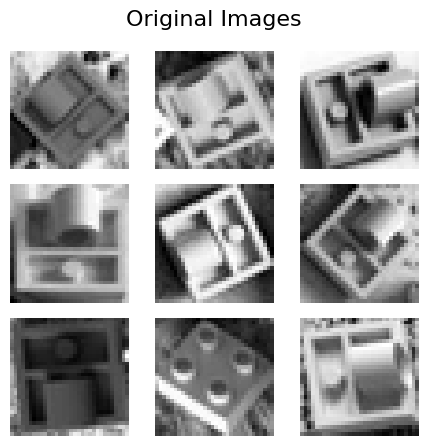

In [90]:
plot_images(x_train, "Original Images")

#### Compressed & Decompressed

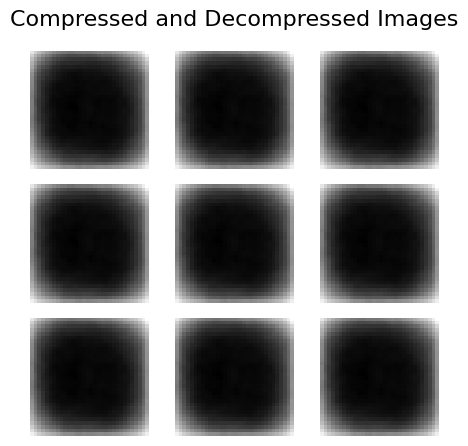

In [91]:
compressed_data = k_means.compress(x_test)
decompressed_data = k_means.decompress(compressed_data)
plot_digits(decompressed_data, "Compressed and Decompressed Images")

#### Generation

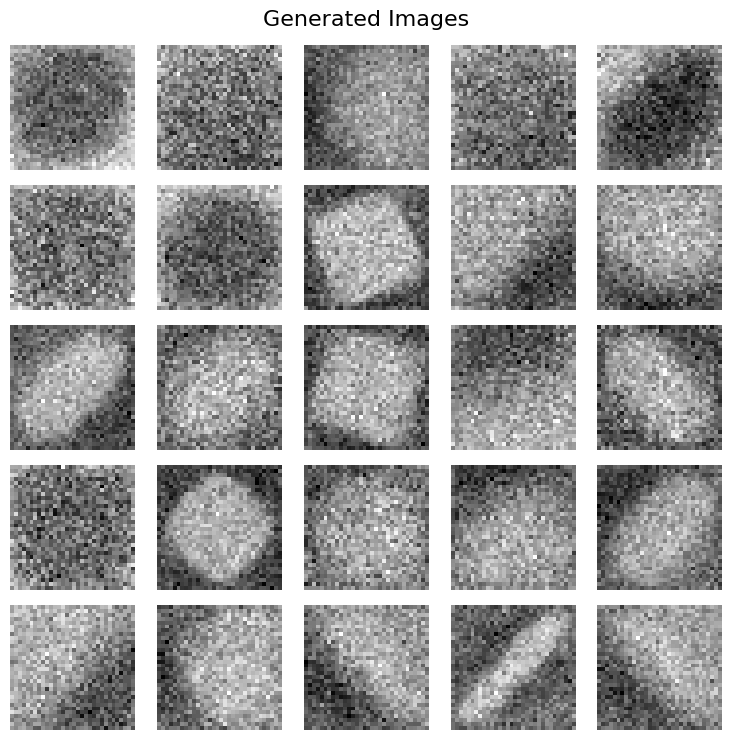

In [92]:
generated_samples = k_means.generate(n_samples=25)
plot_digits(generated_samples, "Generated Images", n_rows=5, n_cols=5)

#### Latent Space Representation

In [93]:
latent_representation_centroid = k_means.compress(x_test)

latent_representation_distance = np.array([k_means._KMeans__euclidean(x, k_means.centroids) for x in x_test])

#### Inter-Cluster Distance Heatmap

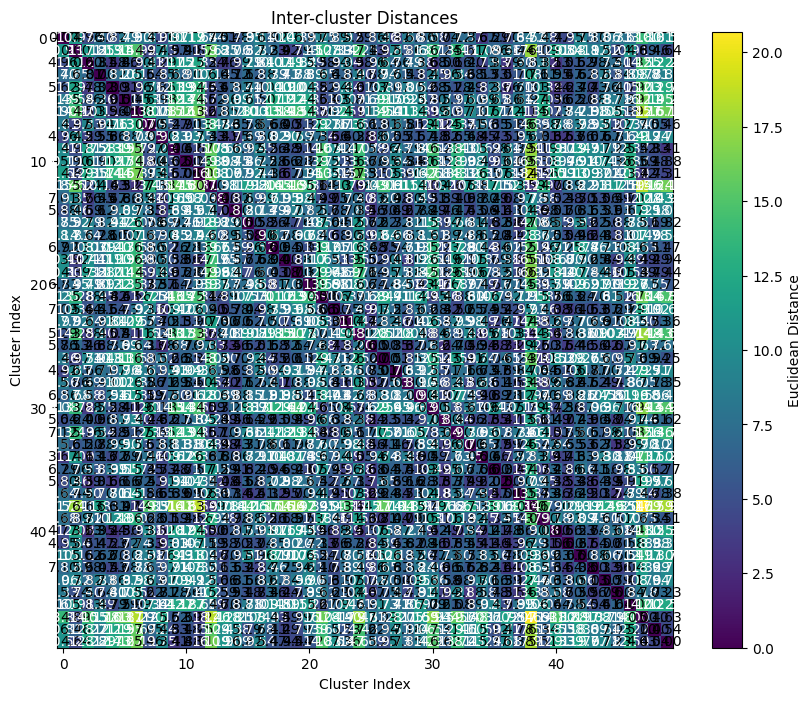

In [94]:
centroids_array = np.array(k_means.centroids)
centroid_distances = np.sqrt(
    ((centroids_array[:, None, :] - centroids_array[None, :, :]) ** 2).sum(axis=2)
)

plt.figure(figsize=(10, 8))
plt.imshow(centroid_distances, cmap="viridis")
plt.colorbar(label="Euclidean Distance")
plt.title("Inter-cluster Distances")
plt.xlabel("Cluster Index")
plt.ylabel("Cluster Index")
for i in range(n_clusters):
    for j in range(n_clusters):
        plt.text(
            j,
            i,
            f"{centroid_distances[i, j]:.2f}",
            ha="center",
            va="center",
            color=(
                "white"
                if centroid_distances[i, j] > np.median(centroid_distances)
                else "black"
            ),
        )
plt.show()

#### Cluster Distribution

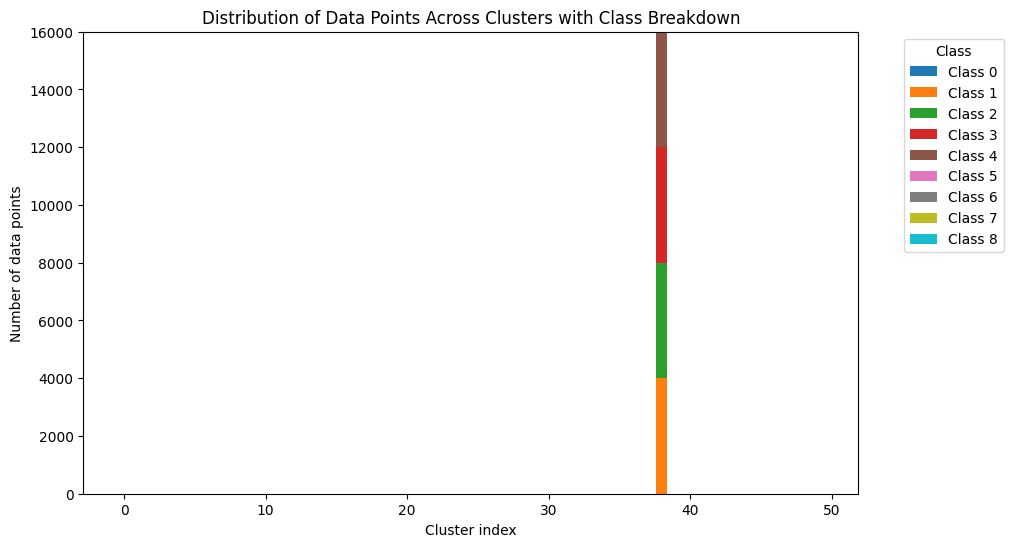

In [95]:
n_classes = len(np.unique(y_train))
cluster_class_counts = np.zeros((n_clusters, n_classes), dtype=int)

for cluster_idx, class_label in zip(compressed_data, y_train):
    cluster_class_counts[cluster_idx, class_label] += 1

colors = plt.cm.tab10(np.linspace(0, 1, n_classes))

plt.figure(figsize=(10, 6))
bottom = np.zeros(n_clusters)

for class_idx in range(n_classes):
    counts = cluster_class_counts[:, class_idx]
    plt.bar(range(n_clusters), counts, bottom=bottom, color=colors[class_idx], label=f'Class {class_idx}')
    bottom += counts

plt.xlabel("Cluster index")
plt.ylabel("Number of data points")
plt.title("Distribution of Data Points Across Clusters with Class Breakdown")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()